# Sawyer Jacobson
## Data Science Capstone, Final Project
## Using Machine Learning to Predict NHL Game Outcomes

### 5/22/2021

This project will use data scraped from the NHL statsapi on the overall team and player levels to predict the outcome of regular season NHL games. 
This is a binary classification problem so the appropriate algorithms will be used. I am particularly interested in obtaining the probability of 
winning for a team in the game. The target for predictions will be whether or not the home team won/will win and the associated probabilities.

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
player_stats = pd.read_csv("data/game_player_stats.csv")
goalie_stats = pd.read_csv("data/game_goalie_stats.csv")
game_results = pd.read_csv("data/game_results.csv")
team_stats_game = pd.read_csv("data/game_team_stats.csv")
officials_game = pd.read_csv("data/game_officials.csv")

game_results = game_results.query("gameID <= 2019021082")
team_stats_game = team_stats_game.query("gameID <= 2019021082")

## setting the ID columns to characters
# game results IDs
game_ID_cols = game_results.filter(like="ID").columns.to_list()
game_results[game_ID_cols] = game_results[game_ID_cols].astype(str)

# team stats IDs
ID_cols = team_stats_game.filter(like="ID").columns.to_list()
team_stats_game[ID_cols] = team_stats_game[ID_cols].astype(str)

# player stats IDs
player_ID_cols = player_stats.filter(like="ID").columns.to_list()
player_stats[player_ID_cols] = player_stats[player_ID_cols].astype(str)

# goalie stats IDs
goalie_ID_cols = goalie_stats.filter(like="ID").columns.to_list()
goalie_stats[goalie_ID_cols] = goalie_stats[goalie_ID_cols].astype(str)

# dropping periods played column. Not going to do much good right now
team_stats_game.drop(columns="periodsPlayed", inplace=True)

# converting game dateTime to a date
game_results["dateTime"] = pd.to_datetime(game_results.dateTime).dt.date

player_stats.shape
goalie_stats.shape
game_results.shape
team_stats_game.shape
officials_game.shape

(422016, 27)

(25252, 24)

(11724, 12)

(23445, 17)

(46897, 3)

# Exploratory data analysis

First we'll check to see that all the data game in in the proper format. Some of the player ice time columns will need to be fixed using the function used for the player analysis project.

Also check to see what data is missing. Since I collected the data in a specific manner, missing data should be just the absence of data and in most cases will mean 0, False, whatever is the appropriate base case for that type of variable.

Since our interest is in the game data, let's see how the games are distributed in terms of results and scoring.

In [3]:
pd.set_option("max_info_columns", player_stats.shape[1])
pd.set_option("max_columns", player_stats.shape[1])

# checking the data types of each column to see what else needs to be cleaned
player_stats.info()
goalie_stats.info()
game_results.info()
team_stats_game.info()
officials_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422016 entries, 0 to 422015
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameID                422016 non-null  object 
 1   playerID              422016 non-null  object 
 2   fullName              422016 non-null  object 
 3   position              422016 non-null  object 
 4   homeAway              422016 non-null  object 
 5   teamID                422016 non-null  object 
 6   teamName              422016 non-null  object 
 7   timeOnIce             422016 non-null  object 
 8   assists               422016 non-null  int64  
 9   goals                 422016 non-null  int64  
 10  shots                 422016 non-null  int64  
 11  hits                  422016 non-null  int64  
 12  powerPlayGoals        422016 non-null  int64  
 13  powerPlayAssists      422016 non-null  int64  
 14  penaltyMinutes        422016 non-null  int64  
 15  

Looks like everythink actually came in pretty clean! The time on ice variables need to be fixed as expected, but everything else came through nicely!

In [4]:
player_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'shots', 'hits',
       'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins',
       'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals',
       'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce',
       'powerPlayTimeOnIce', 'shortHandedTimeOnIce', 'faceOffPct'],
      dtype='object')

In [5]:
game_results.tail()

,gameID,season,dateTime,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
11719,2019021078,20192020,2020-03-11,R,24,Anaheim Ducks,9,Ottawa Senators,5,2,True,Honda Center
11720,2019021079,20192020,2020-03-12,R,16,Chicago Blackhawks,28,San Jose Sharks,6,2,True,United Center
11721,2019021080,20192020,2020-03-12,R,22,Edmonton Oilers,52,Winnipeg Jets,2,4,False,Rogers Place
11722,2019021081,20192020,2020-03-12,R,21,Colorado Avalanche,3,New York Rangers,3,2,True,Pepsi Center
11723,2019021082,20192020,2020-03-12,R,26,Los Angeles Kings,9,Ottawa Senators,3,2,True,STAPLES Center


True     0.543671
False    0.456329
Name: homeTeamWin, dtype: float64

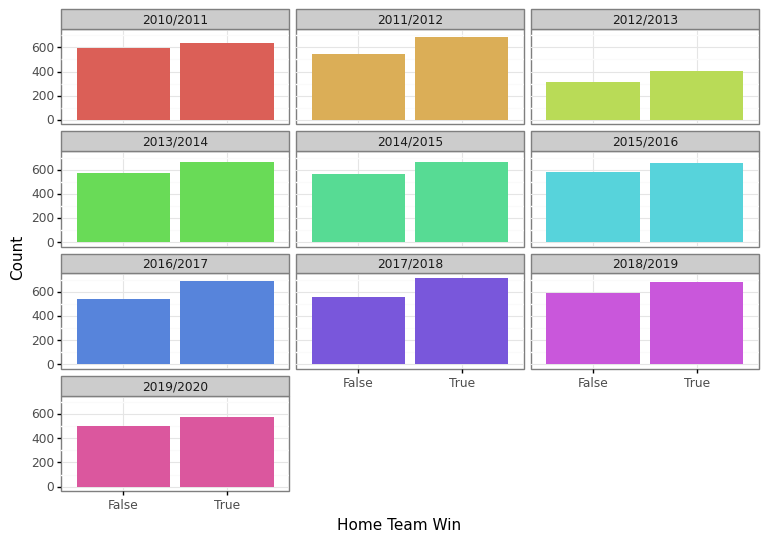

<ggplot: (355544953)>

In [6]:
# percentage of games where the home team won
game_results.homeTeamWin.value_counts()/game_results.shape[0]

def add_season(df):
    return df['gameID'].astype(str).str[0:4] + "/" + (df['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

# adding a season column
game_results["season"] = add_season(game_results)#game_results['gameID'].astype(str).str[0:4] + "/" + (game_results['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

plotnine.options.figure_size = (9, 6)

(
ggplot(game_results, aes(x = "homeTeamWin", fill = 'season')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ season", ncol = 3) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Win", y = "Count")
)

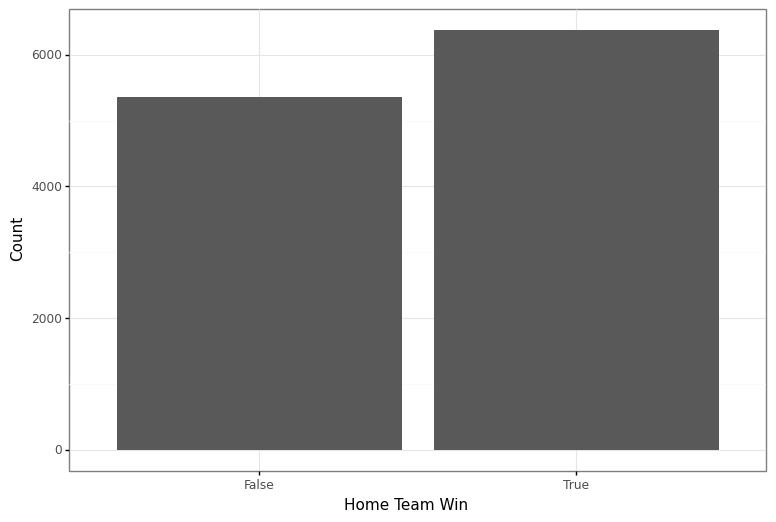

<ggplot: (349661645)>

In [7]:
(
ggplot(game_results, aes(x = "homeTeamWin")) + 
    geom_bar() + 
    theme_bw() + 
    labs(x = "Home Team Win", y = "Count")
)

In [8]:
pd.crosstab(index=game_results['season'], columns=game_results['homeTeamWin'])

homeTeamWin,False,True
season,,
2010/2011,592,638
2011/2012,543,687
2012/2013,311,409
2013/2014,570,660
2014/2015,564,666
2015/2016,579,651
2016/2017,542,688
2017/2018,555,716
2018/2019,589,682


In almost every season from the past decade, the home team has won a slight majority of the games. The 2019/2020 season seemed to be the exception, potentially due to the season being delayed and cut short because of COVID-19.

Below, we'll create a new dataset that has a teams cumulative statistics throughout a season. These stats will be used as features in the predictive model. The difference between 2 teams cumulative stats up to the desired game in a season will be used (home team - away team) which should help determine which team is doing better in that season as well as a certain difference in performance. I intend to include other features such as whether the starter goalie has played consecutive games or not and also take into account the roster for each team. This last feature will be something of a pseudo roster strength going into the game. Theoretically this should help because the roster strength would be diminished if a star player was out hurt or something.

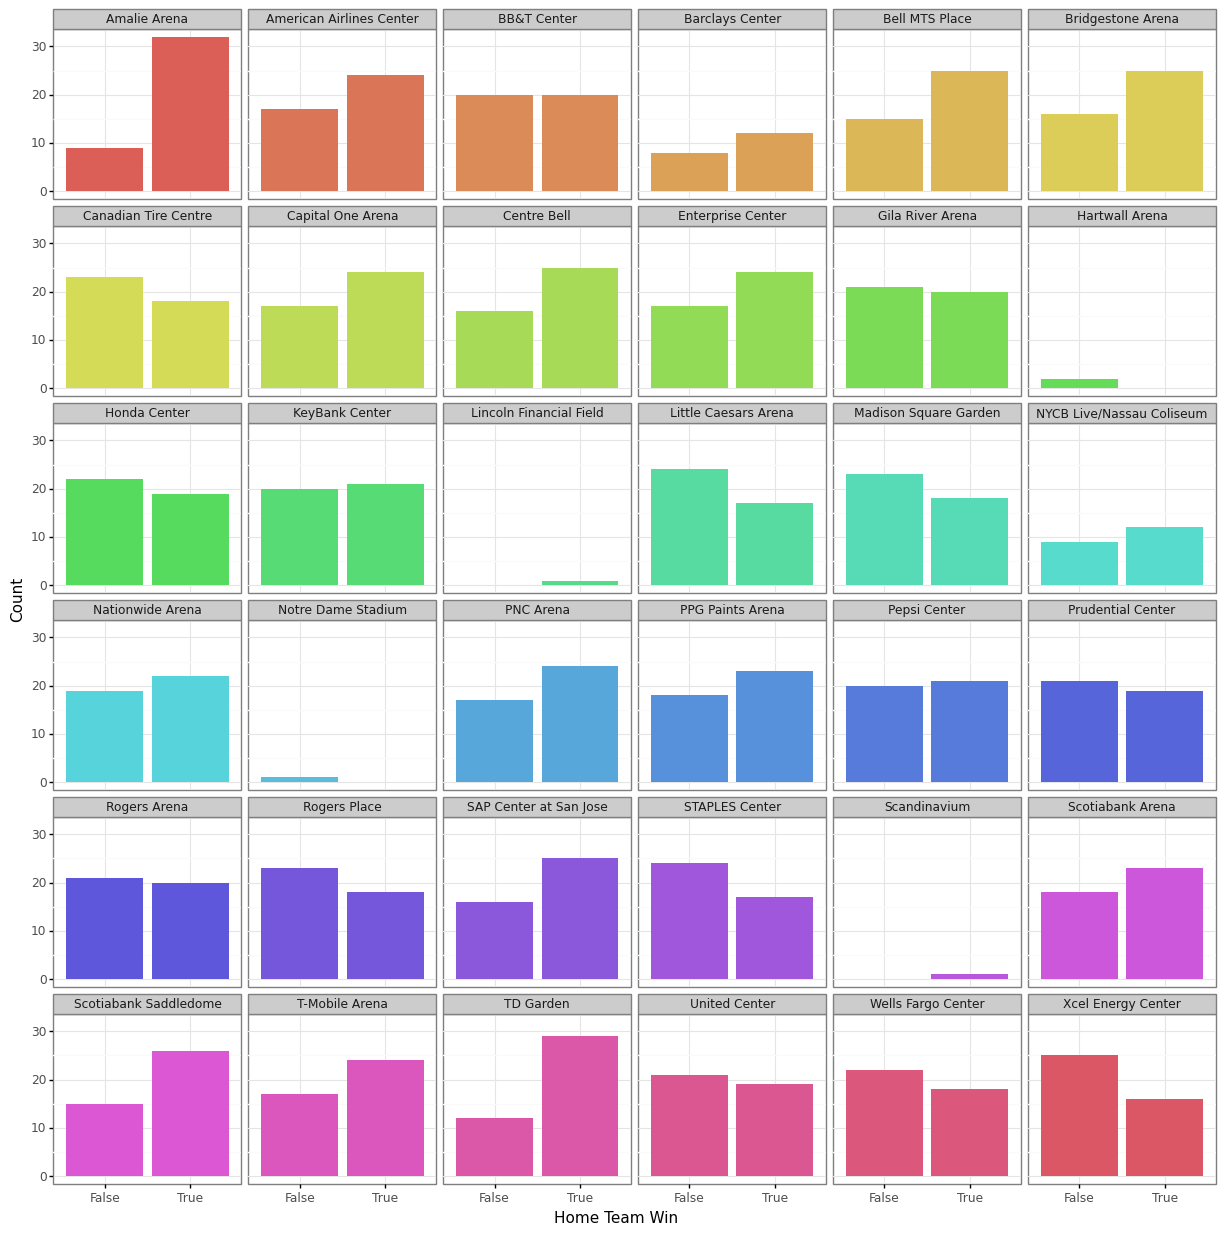

<ggplot: (349368019)>

In [9]:
plotnine.options.figure_size = (15, 15)

(
ggplot(game_results.query("season == '2018/2019'"), aes(x = "homeTeamWin", fill = 'venue')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ venue", ncol = 6) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Win", y = "Count")
)

# Data Preprocessing

Here we will do the feature engineering and manipulation to get the player and team stat datasets into a form usuable for modeling. The desired modeling dataset will be the home team stats minus the away team stats. Therefore, positive numbers will signify the home team as higher stats up to that point in the season, and negative numbers will indicate that the away team has higher stats.

In [10]:
# adding win and losing streaks to the team stats
def win_lose(df):
    win_streak=0
    df["winStreak"] = 0
    lose_streak=0
    df["loseStreak"] = 0
    games_won=0
    games_lost = 0
    df["gamesWon"] = 0
    df["gamesLost"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "homeAway"] == "home" and df.loc[index, "homeTeamWin"]) or (df.loc[index, "homeAway"] == "away" and not df.loc[index, "homeTeamWin"]):
            win_streak+=1
            df.loc[index, "winStreak"] = win_streak
            lose_streak=0
            df.loc[index, "loseStreak"] = lose_streak
            games_won+=1
            df.loc[index, "gamesWon"] = games_won
            df.loc[index, "gamesLost"] = games_lost
        else:
            win_streak=0
            df.loc[index, "winStreak"] = win_streak
            lose_streak+=1
            df.loc[index, "loseStreak"] = lose_streak
            games_lost+=1
            df.loc[index, "gamesWon"] = games_won
            df.loc[index, "gamesLost"] = games_lost
    return(df)


team_stats_game['season'] = add_season(team_stats_game)
team_stats_game['gamesPlayed'] = 1
team_num_vars = team_stats_game.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_team_num_stats = team_stats_game \
    .groupby(by=['teamID', 'season'])[team_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_team_stats = pd.concat([team_stats_game.drop(columns=team_num_vars), cum_team_num_stats], axis="columns")
team_percent_cols = cum_team_stats.filter(like="Percentage").columns.to_list()
cum_team_stats[team_percent_cols] = cum_team_stats[team_percent_cols].apply(lambda x: x/cum_team_stats["gamesPlayed"])

# adding win/lose and streak columns
cum_team_stats = cum_team_stats \
    .groupby(['teamID', "season"]) \
    .apply(win_lose)


In [11]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23440,2019021080,away,False,Paul Maurice,52,Winnipeg Jets,2019/2020,213,525,2222,18.564789,42.0,205.0,50.097183,874,484,745,1550,71,4,0,37,34
23441,2019021081,home,True,Jared Bednar,21,Colorado Avalanche,2019/2020,236,597,2257,18.472857,46.0,241.0,49.755714,1030,564,543,1296,70,1,0,42,28
23442,2019021081,away,True,David Quinn,3,New York Rangers,2019/2020,233,781,2175,23.380000,52.0,227.0,46.544286,1050,567,864,1527,70,0,1,37,33
23443,2019021082,home,True,Todd McLellan,26,Los Angeles Kings,2019/2020,177,479,2325,18.891429,33.0,193.0,51.008571,861,365,691,1460,70,7,0,29,41


In [12]:
# cum_team_stats.query("season == '2010/2011' & gamesPlayed == 1")

Here, the same process will be used to create a cumulative player stats dataset for each season.

In [13]:
player_stats["season"] = add_season(player_stats)
player_stats["gamesPlayed"] = 1
player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]] = player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]].fillna(value=0)

# adding a point streak column for players
def point_streak(df):
    point_streak=0
    df["pointStreak"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "assists"] > 0 or df.loc[index, 'goals'] > 0):
            point_streak+=1
            df.loc[index, "pointStreak"] = point_streak
        else:
            point_streak=0
            df.loc[index, "pointStreak"] = point_streak
    return(df)

# function to clean the time on ice from minutes:seconds format to a decimal
def clean_toi(x):
    time = x.str.split(":")
    minutes = time.str.get(0)
    seconds = time.str.get(1).astype(int)*100/60
    return minutes + "." + seconds.round().astype(int).astype(str)

time_on_ice_cols = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce', 'shortHandedTimeOnIce']
# had to change the clean_toi function a few times because the list wasn't working right...
player_stats[time_on_ice_cols] = player_stats[time_on_ice_cols].apply(clean_toi).astype(float)

player_num_vars = player_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# adding player point streak column
player_stats = player_stats \
    .groupby(['playerID', 'season']) \
    .apply(point_streak)

# creating cumulative totals for the 
cum_player_num_stats = player_stats \
    .groupby(by=['playerID', 'season'])[player_num_vars] \
    .cumsum()

# creating the full cumulative team stats dataframe
cum_player_stats = pd.concat([player_stats.drop(columns=player_num_vars), cum_player_num_stats], 
                             axis="columns")

# turning time on ice stats into season averages
cum_player_stats[time_on_ice_cols] = cum_player_stats[time_on_ice_cols].apply(lambda x: x/cum_player_stats['gamesPlayed'])

# function to determine if a player is on a hot streak
def hot_players(x, thresh):
    return x >= thresh
cum_player_stats["hotPlayer"] = hot_players(cum_player_stats.pointStreak, 2).astype(int)
cum_player_stats["faceOffPct"] = cum_player_stats["faceOffWins"] / cum_player_stats['faceoffTaken']
cum_player_stats["faceOffPct"] = cum_player_stats["faceOffPct"].fillna(value=0)

In [14]:
# cum_player_stats["faceOffPct"] = cum_player_stats["faceOffWins"] / cum_player_stats['faceoffTaken']
# cum_player_stats["faceOffPct"] = cum_player_stats["faceOffPct"].fillna(value=0)
cum_player_stats


,gameID,playerID,fullName,position,homeAway,teamID,teamName,season,pointStreak,timeOnIce,assists,goals,shots,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct,gamesPlayed,hotPlayer
0,2010020001,8468778,Colton Orr,R,home,10,Toronto Maple Leafs,2010/2011,0,3.320000,0,0,0,...,0,0,0,0,0,0,1,3.320000,0.000000,0.000000,0.000000,1,0
1,2010020001,8470602,Dion Phaneuf,D,home,10,Toronto Maple Leafs,2010/2011,1,23.750000,1,0,2,...,0,0,1,0,0,3,1,15.180000,6.780000,1.780000,0.000000,1,0
2,2010020001,8465200,Tomas Kaberle,D,home,10,Toronto Maple Leafs,2010/2011,0,23.920000,0,0,2,...,0,0,0,0,0,2,0,16.270000,7.650000,0.000000,0.000000,1,0
3,2010020001,8467400,Francois Beauchemin,D,home,10,Toronto Maple Leafs,2010/2011,0,22.350000,0,0,1,...,0,1,2,0,0,3,0,15.700000,3.420000,3.230000,0.000000,1,0
4,2010020001,8474125,Carl Gunnarsson,D,home,10,Toronto Maple Leafs,2010/2011,0,17.550000,0,0,1,...,0,1,3,0,0,2,1,13.320000,1.470000,2.770000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422011,2019021082,8478469,Thomas Chabot,D,away,9,Ottawa Senators,2019/2020,0,26.043239,33,6,186,...,0,42,87,0,0,85,-18,22.531972,3.285493,0.274366,0.000000,71,0
422012,2019021082,8477963,Jayce Hawryluk,R,away,9,Ottawa Senators,2019/2020,1,11.121538,7,3,26,...,12,11,12,0,0,9,1,10.987308,0.164231,0.015385,0.333333,26,0
422013,2019021082,8478870,Rudolfs Balcers,L,away,9,Ottawa Senators,2019/2020,0,12.236000,2,1,23,...,2,7,5,0,0,7,-2,10.612667,1.738000,0.000000,0.000000,15,0
422014,2019021082,8476285,Matthew Peca,C,away,9,Ottawa Senators,2019/2020,0,10.442143,2,0,7,...,79,0,1,0,0,4,-4,9.857143,0.105714,0.627143,0.544304,14,0


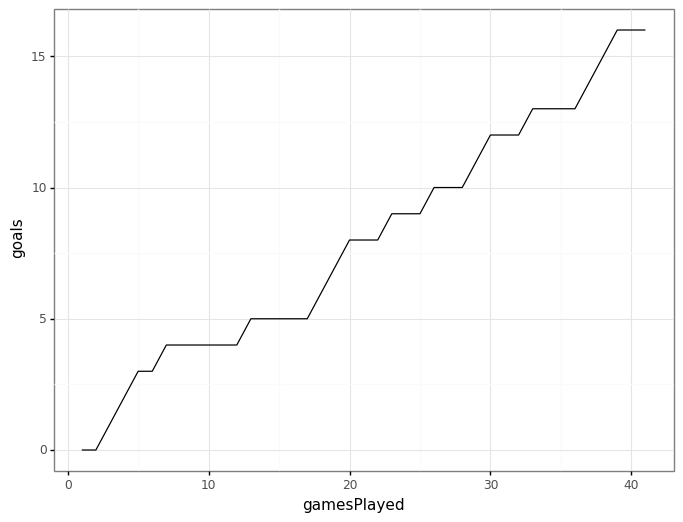

<ggplot: (356496535)>

In [15]:
plotnine.options.figure_size = (8, 6)

(
ggplot(cum_player_stats.query("fullName == 'Sidney Crosby' & season == '2019/2020'"), aes(x = "gamesPlayed", y = "goals")) + 
    geom_line() + 
    theme_bw()
)

Lastly we'll do the same cumulative stats for goalies.


In [16]:
goalie_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'pim', 'shots', 'saves',
       'powerPlaySaves', 'shortHandedSaves', 'evenSaves',
       'shortHandedShotsAgainst', 'evenShotsAgainst', 'powerPlayShotsAgainst',
       'decision', 'savePercentage', 'powerPlaySavePercentage',
       'shortHandedSavePercentage', 'evenStrengthSavePercentage'],
      dtype='object')

In [17]:
goalie_stats["season"] = add_season(goalie_stats)
goalie_stats["gamesPlayed"] = 1
goalie_num_vars = goalie_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_goalie_num_stats = goalie_stats \
    .groupby(by=['playerID', 'season'])[goalie_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_goalie_stats = pd.concat([goalie_stats.drop(columns=goalie_num_vars), cum_goalie_num_stats], axis="columns")

save_percentages = ["savePercentage", "powerPlaySavePercentage", "shortHandedSavePercentage", "evenStrengthSavePercentage"]

cum_goalie_stats[save_percentages] = cum_goalie_stats[save_percentages].fillna(value=0).apply(lambda x: x/cum_goalie_stats["gamesPlayed"])

In [18]:
cum_goalie_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,decision,season,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,savePercentage,powerPlaySavePercentage,shortHandedSavePercentage,evenStrengthSavePercentage,gamesPlayed
0,2010020001,8462044,Jean-Sebastien Giguere,G,home,10,Toronto Maple Leafs,58:49,W,2010/2011,0,0,0,28,26,3,2,21,2,23,3,92.857143,100.000000,100.000000,91.304348,1
1,2010020001,8471679,Carey Price,G,away,8,Montréal Canadiens,58:59,L,2010/2011,0,0,0,24,21,2,0,19,0,22,2,87.500000,100.000000,0.000000,86.363636,1
2,2010020002,8470594,Marc-Andre Fleury,G,home,5,Pittsburgh Penguins,58:47,L,2010/2011,0,0,0,27,24,3,1,20,2,21,4,88.888889,75.000000,50.000000,95.238095,1
3,2010020002,8475683,Sergei Bobrovsky,G,away,4,Philadelphia Flyers,60:00,W,2010/2011,0,0,0,31,29,3,1,25,1,26,4,93.548387,75.000000,100.000000,96.153846,1
4,2010020003,8473404,Niklas Backstrom,G,home,30,Minnesota Wild,58:45,L,2010/2011,0,0,0,31,27,1,1,25,1,27,3,87.096774,33.333333,100.000000,92.592593,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25247,2019021080,8476945,Connor Hellebuyck,G,away,52,Winnipeg Jets,60:00,W,2019/2020,2,0,0,1796,1656,189,49,1418,50,1530,216,90.738610,75.395457,0.000000,91.105086,58
25248,2019021081,8480925,Pavel Francouz,G,home,21,Colorado Avalanche,62:50,W,2019/2020,0,0,2,996,919,114,34,771,34,837,125,89.236823,84.517974,52.941176,88.852794,34
25249,2019021081,8480382,Alexandar Georgiev,G,away,3,New York Rangers,61:44,L,2019/2020,1,0,0,1063,967,175,27,765,29,837,197,89.961725,86.220373,46.323529,90.400529,34
25250,2019021082,8477361,Calvin Petersen,G,home,26,Los Angeles Kings,59:34,W,2019/2020,0,0,0,269,248,34,8,206,8,224,37,91.883237,92.261905,75.000000,91.417911,8


In [19]:
def goalie_consec_games(df):
    consec_games = 0
    df["goalieConsecutiveGames"] = 0
    for index, row in df.iterrows():
        if (df.loc[index, "playerID"] == df.shift(1).loc[index, "playerID"]):
            consec_games+=1
            df.loc[index, "goalieConsecutiveGames"] = consec_games
        else:
            consec_games=0
            df.loc[index, "goalieConsecutiveGames"] = consec_games
    
    return(df)

cum_goalie_stats = cum_goalie_stats \
    .groupby(['teamID', 'season']) \
    .apply(goalie_consec_games)
# goalie_consec_games(cum_goalie_stats.query("teamID == '10' & season == '2011/2012'"))

# cum_goalie_stats.query("teamID == '10' & season == '2011/2012'").shift(1)#.iloc[0].shift(1)

In [22]:
cum_goalie_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,timeOnIce,decision,season,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,savePercentage,powerPlaySavePercentage,shortHandedSavePercentage,evenStrengthSavePercentage,gamesPlayed,goalieConsecutiveGames
0,2010020001,8462044,Jean-Sebastien Giguere,G,home,10,Toronto Maple Leafs,58:49,W,2010/2011,0,0,0,28,26,3,2,21,2,23,3,92.857143,100.000000,100.000000,91.304348,1,0
1,2010020001,8471679,Carey Price,G,away,8,Montréal Canadiens,58:59,L,2010/2011,0,0,0,24,21,2,0,19,0,22,2,87.500000,100.000000,0.000000,86.363636,1,0
2,2010020002,8470594,Marc-Andre Fleury,G,home,5,Pittsburgh Penguins,58:47,L,2010/2011,0,0,0,27,24,3,1,20,2,21,4,88.888889,75.000000,50.000000,95.238095,1,0
3,2010020002,8475683,Sergei Bobrovsky,G,away,4,Philadelphia Flyers,60:00,W,2010/2011,0,0,0,31,29,3,1,25,1,26,4,93.548387,75.000000,100.000000,96.153846,1,0
4,2010020003,8473404,Niklas Backstrom,G,home,30,Minnesota Wild,58:45,L,2010/2011,0,0,0,31,27,1,1,25,1,27,3,87.096774,33.333333,100.000000,92.592593,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25247,2019021080,8476945,Connor Hellebuyck,G,away,52,Winnipeg Jets,60:00,W,2019/2020,2,0,0,1796,1656,189,49,1418,50,1530,216,90.738610,75.395457,0.000000,91.105086,58,5
25248,2019021081,8480925,Pavel Francouz,G,home,21,Colorado Avalanche,62:50,W,2019/2020,0,0,2,996,919,114,34,771,34,837,125,89.236823,84.517974,52.941176,88.852794,34,4
25249,2019021081,8480382,Alexandar Georgiev,G,away,3,New York Rangers,61:44,L,2019/2020,1,0,0,1063,967,175,27,765,29,837,197,89.961725,86.220373,46.323529,90.400529,34,0
25250,2019021082,8477361,Calvin Petersen,G,home,26,Los Angeles Kings,59:34,W,2019/2020,0,0,0,269,248,34,8,206,8,224,37,91.883237,92.261905,75.000000,91.417911,8,0


In [23]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23440,2019021080,away,False,Paul Maurice,52,Winnipeg Jets,2019/2020,213,525,2222,18.564789,42.0,205.0,50.097183,874,484,745,1550,71,4,0,37,34
23441,2019021081,home,True,Jared Bednar,21,Colorado Avalanche,2019/2020,236,597,2257,18.472857,46.0,241.0,49.755714,1030,564,543,1296,70,1,0,42,28
23442,2019021081,away,True,David Quinn,3,New York Rangers,2019/2020,233,781,2175,23.380000,52.0,227.0,46.544286,1050,567,864,1527,70,0,1,37,33
23443,2019021082,home,True,Todd McLellan,26,Los Angeles Kings,2019/2020,177,479,2325,18.891429,33.0,193.0,51.008571,861,365,691,1460,70,7,0,29,41


In [26]:
# counting the number of hot players each team has after each game
game_hot_players = cum_player_stats \
    .groupby(["gameID", "teamID", "season"])['hotPlayer'] \
    .sum() \
    .reset_index()

# merging these in
cum_team_stats = pd.merge(cum_team_stats, game_hot_players, on=["gameID", "teamID", "season"])

In [25]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.000000,0.0,5.0,46.500000,22,6,16,27,1,1,0,1,0,0
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.000000,0.0,3.0,53.500000,21,7,7,34,1,0,1,0,1,0
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.000000,1.0,5.0,60.700000,14,9,11,32,1,0,1,0,1,0
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.000000,1.0,4.0,39.300000,16,1,9,34,1,1,0,1,0,0
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.000000,2.0,5.0,61.200000,19,8,11,19,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23440,2019021080,away,False,Paul Maurice,52,Winnipeg Jets,2019/2020,213,525,2222,18.564789,42.0,205.0,50.097183,874,484,745,1550,71,4,0,37,34,6
23441,2019021081,home,True,Jared Bednar,21,Colorado Avalanche,2019/2020,236,597,2257,18.472857,46.0,241.0,49.755714,1030,564,543,1296,70,1,0,42,28,2
23442,2019021081,away,True,David Quinn,3,New York Rangers,2019/2020,233,781,2175,23.380000,52.0,227.0,46.544286,1050,567,864,1527,70,0,1,37,33,4
23443,2019021082,home,True,Todd McLellan,26,Los Angeles Kings,2019/2020,177,479,2325,18.891429,33.0,193.0,51.008571,861,365,691,1460,70,7,0,29,41,5


In [27]:
cum_team_num_vars = cum_team_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

shifted_team_stats = cum_team_stats.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)
short_team_stats = cum_team_stats.drop(columns=cum_team_num_vars)#.groupby(['teamID', "season"])[cum_team_num_vars].shift(1)

proper_team_stats = pd.concat([short_team_stats, shifted_team_stats], axis="columns").dropna()

# cum_team_stats.groupby(['teamID', "season"]).shift(1).dropna()

In [30]:
proper_team_stats.head()

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
14,2010020008,home,True,Paul Maurice,12,Carolina Hurricanes,2010/2011,4.0,10.0,31.0,40.0,2.0,5.0,38.8,19.0,3.0,11.0,14.0,1.0,1.0,0.0,1.0,0.0,0.0
15,2010020008,away,True,Todd Richards,30,Minnesota Wild,2010/2011,3.0,10.0,29.0,40.0,2.0,5.0,61.2,19.0,8.0,11.0,19.0,1.0,0.0,1.0,0.0,1.0,0.0
24,2010020013,home,False,Lindy Ruff,7,Buffalo Sabres,2010/2011,2.0,12.0,36.0,20.0,1.0,5.0,43.4,20.0,5.0,8.0,22.0,1.0,1.0,0.0,1.0,0.0,0.0
26,2010020014,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3.0,6.0,24.0,0.0,0.0,5.0,46.5,22.0,6.0,16.0,27.0,1.0,1.0,0.0,1.0,0.0,0.0
27,2010020014,away,True,Cory Clouston,9,Ottawa Senators,2010/2011,1.0,12.0,26.0,0.0,0.0,5.0,56.6,7.0,16.0,18.0,26.0,1.0,0.0,1.0,0.0,1.0,0.0


In [31]:
home_team = proper_team_stats.query("homeAway == 'home'").sort_values('gameID').reset_index().drop(columns="index")

In [32]:
away_team = proper_team_stats.query("homeAway == 'away'").sort_values('gameID').reset_index().drop(columns="index")

In [33]:
full_gameID_stats = pd.merge(home_team.gameID, away_team.gameID, how="inner")
full_gameID_stats['gameID'] = full_gameID_stats.gameID.astype(str)
home_team_clean = pd.merge(home_team, full_gameID_stats, how="inner", on="gameID")
away_team_clean = pd.merge(away_team, full_gameID_stats, how="inner", on="gameID")

prior_game_stats = pd.concat([full_gameID_stats, home_team_clean[cum_team_num_vars].subtract(away_team_clean[cum_team_num_vars])], axis="columns")

In [34]:
prediction_df = pd.merge(game_results.filter(items=['gameID', 'season', "homeTeamWin"]), prior_game_stats, how = "inner", on="gameID")


In [35]:
prediction_df['homeTeamWin'] = prediction_df.homeTeamWin.astype(int)

In [36]:
prediction_df

,gameID,season,homeTeamWin,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
0,2010020008,2010/2011,1,1.0,0.0,2.0,0.000000,0.0,0.0,-22.400000,0.0,-5.0,0.0,-5.0,0.0,1.0,-1.0,1.0,-1.0,0.0
1,2010020014,2010/2011,1,2.0,-6.0,-2.0,0.000000,0.0,0.0,-10.100000,15.0,-10.0,-2.0,1.0,0.0,1.0,-1.0,1.0,-1.0,0.0
2,2010020016,2010/2011,0,0.0,0.0,3.0,20.000000,1.0,2.0,7.200000,-7.0,2.0,4.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010020017,2010/2011,1,-1.0,4.0,1.0,-100.000000,-1.0,2.0,7.900000,4.0,11.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010020021,2010/2011,0,-1.0,-20.0,-5.0,28.600000,2.0,1.0,-18.100000,2.0,6.0,-5.0,-2.0,0.0,-1.0,1.0,-1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11539,2019021078,2019/2020,1,-9.0,50.0,-15.0,-1.666025,-5.0,-22.0,0.508654,-122.0,2.0,-6.0,-348.0,1.0,-2.0,1.0,3.0,-2.0,-3.0
11540,2019021079,2019/2020,1,24.0,-175.0,117.0,-0.963768,-1.0,28.0,1.224638,66.0,-15.0,75.0,-32.0,0.0,0.0,-1.0,2.0,-2.0,-3.0
11541,2019021080,2019/2020,0,12.0,54.0,-135.0,8.991429,17.0,-6.0,-1.348571,185.0,104.0,103.0,41.0,0.0,-3.0,1.0,1.0,-1.0,-1.0
11542,2019021081,2019/2020,1,2.0,-182.0,86.0,-5.557971,-8.0,13.0,3.231884,-25.0,-13.0,-327.0,-238.0,0.0,-1.0,1.0,4.0,-4.0,-4.0


In [37]:
prediction_df.homeTeamWin.value_counts()

1    6280
0    5264
Name: homeTeamWin, dtype: int64

# Predictions

This method will train on the data from 2010-2019 seasons and test on the 2019/2020 season. Very much just a test to see where we're at and get a baseline from a very basic Logistic Regression model.

In [38]:
X_train, X_test = prediction_df.query('season != "2019/2020"').drop(columns=["gameID", "season", "homeTeamWin"]), prediction_df.query('season == "2019/2020"').drop(columns=["gameID", "season", "homeTeamWin"])

y_train, y_test = prediction_df.query('season != "2019/2020"')['homeTeamWin'], prediction_df.query('season == "2019/2020"')['homeTeamWin']

X_train.shape
y_train.shape
X_test.shape
y_test.shape

(10480, 17)

(10480,)

(1064, 17)

(1064,)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression(max_iter=1e4)

log_reg.fit(X_train, y_train)

train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

pd.crosstab(y_train, train_preds)
pd.crosstab(y_test, test_preds)

accuracy_score(y_train, train_preds)
accuracy_score(y_test, test_preds)

y_test.value_counts()/len(y_test)

print(classification_report(y_test, test_preds))

LogisticRegression(max_iter=10000.0)

col_0,0,1
homeTeamWin,,
0,1302,3464
1,1031,4683


col_0,0,1
homeTeamWin,,
0,117,381
1,91,475


0.5710877862595419

0.556390977443609

1    0.531955
0    0.468045
Name: homeTeamWin, dtype: float64

              precision    recall  f1-score   support

           0       0.56      0.23      0.33       498
           1       0.55      0.84      0.67       566

    accuracy                           0.56      1064
   macro avg       0.56      0.54      0.50      1064
weighted avg       0.56      0.56      0.51      1064



In [40]:
for var, coef in zip(X_train.columns.values, log_reg.coef_[0]):
    print(var, ": ", coef, sep='')

goals: 0.0005942173865046467
pim: 0.00038732505413035867
shots: 0.0006738898870729913
powerPlayPercentage: 0.0024085555964732633
powerPlayGoals: 0.0037233162358457726
powerPlayOpportunities: -0.0015834775428572895
faceOffWinPercentage: 0.009634563159510829
blocked: -0.0004359869191392474
takeaways: -0.0001525839286285692
giveaways: 7.772659027129089e-05
hits: 2.149397609911958e-05
gamesPlayed: -0.028901542487552345
winStreak: 0.006061097131489746
loseStreak: 0.008628456975365859
gamesWon: 0.002590156433097467
gamesLost: -0.031491698920639355
hotPlayer: -0.008163752085685505


So right above here can be considered a base model, training on the 2010-2019 season data and testing on the 2019/2020 games. Not great accuracy, but that is to be expected. Theoretically it should be fine to make normal train/test sets since we want the model to learn how to predict all games. In a real scenario, we would train and validate on all data up to a season, but we can also experiment this way as well. This will give a few different approaches to modeling game data.

Other models will be included in the final training/predicting as well. This will setup a couple different approaches. Could also train/validate a model on all data before a certain season and then test predictions on the next season. An example would be what was already done, but continue to do for all other seasons in the span we collected data for. Theoretically, more data being available for training should help in prediction accuracies as we get closer to current seasons, but given the nature of hockey games, there might not be any benefit which would also be interesting as well. There is the theoretical limit of game results being able to be predicted only ~62% of the time. I'm hopeful to at least get close to this number using many different models and a model ensemble. If accuracies don't change, then better features might be needed which will have to happen later. 

I should also use models that can output probabilities as well since that would be the interesting thing to see in an app: what's the probability team X will beat team Y in this game given the current status of the season. Accuracy will be used as the metric because it will only really matter if the prediction is wrong. False positives or negatives carry equal weight in that we "lost the bet" in a sports gambling situation.

The aspect of "puck luck" has to be kept in mind because of how much affect a single lucky play can have on the outcome of a game. Predicting on a high level like this won't capture that obviously, and I believe that low level prediction model that predicts during games would benefit from a reinforcement learning approach. 

Could play around with a random multiplier to win probabilites and use that in a simulation style as well.

In [54]:
log_reg.predict_proba(X_test.iloc[0:3])

array([[0.49381669, 0.50618331],
       [0.41580777, 0.58419223],
       [0.45373921, 0.54626079]])

In [64]:
X_test.iloc[0:3]
y_test[0:3]
prediction_df.query('season == "2019/2020"').iloc[0:3]

,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
10480,-3.0,-2.0,-13.0,-25.0,-1.0,1.0,-5.60,0.0,-7.0,-10.0,8.0,0.0,-1.0,1.0,-1.0,1.0,0.0
10481,-1.0,6.0,2.0,50.0,1.0,0.0,-0.10,11.0,-4.0,-6.0,14.0,0.0,1.0,-1.0,1.0,-1.0,0.0
10482,6.0,12.0,35.0,-3.3,2.0,7.0,1.35,9.0,8.0,5.0,4.0,1.0,2.0,-1.0,2.0,-1.0,5.0


10480    0
10481    1
10482    0
Name: homeTeamWin, dtype: int64

,gameID,season,homeTeamWin,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
10480,2019020017,2019/2020,0,-3.0,-2.0,-13.0,-25.0,-1.0,1.0,-5.60,0.0,-7.0,-10.0,8.0,0.0,-1.0,1.0,-1.0,1.0,0.0
10481,2019020018,2019/2020,1,-1.0,6.0,2.0,50.0,1.0,0.0,-0.10,11.0,-4.0,-6.0,14.0,0.0,1.0,-1.0,1.0,-1.0,0.0
10482,2019020019,2019/2020,0,6.0,12.0,35.0,-3.3,2.0,7.0,1.35,9.0,8.0,5.0,4.0,1.0,2.0,-1.0,2.0,-1.0,5.0


In [70]:
game_results.query('season == "2019/2020"').head(20)
cum_team_stats.query('season == "2019/2020" & gamesPlayed > 1').head()

,gameID,season,dateTime,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
10642,2019020001,2019/2020,2019-10-02,R,10,Toronto Maple Leafs,9,Ottawa Senators,5,3,True,Scotiabank Arena
10643,2019020002,2019/2020,2019-10-03,R,19,St. Louis Blues,15,Washington Capitals,2,3,False,Enterprise Center
10644,2019020003,2019/2020,2019-10-03,R,22,Edmonton Oilers,23,Vancouver Canucks,3,2,True,Rogers Place
10645,2019020004,2019/2020,2019-10-03,R,54,Vegas Golden Knights,28,San Jose Sharks,4,1,True,T-Mobile Arena
10646,2019020005,2019/2020,2019-10-03,R,14,Tampa Bay Lightning,13,Florida Panthers,5,2,True,Amalie Arena
10647,2019020006,2019/2020,2019-10-03,R,3,New York Rangers,52,Winnipeg Jets,6,4,True,Madison Square Garden
10648,2019020007,2019/2020,2019-10-03,R,5,Pittsburgh Penguins,7,Buffalo Sabres,1,3,False,PPG Paints Arena
10649,2019020008,2019/2020,2019-10-03,R,12,Carolina Hurricanes,8,Montréal Canadiens,4,3,True,PNC Arena
10650,2019020009,2019/2020,2019-10-04,R,18,Nashville Predators,30,Minnesota Wild,5,2,True,Bridgestone Arena
10651,2019020010,2019/2020,2019-10-04,R,25,Dallas Stars,6,Boston Bruins,1,2,False,American Airlines Center


,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits,gamesPlayed,winStreak,loseStreak,gamesWon,gamesLost,hotPlayer
21306,2019020013,away,False,Paul Maurice,52,Winnipeg Jets,2019/2020,8,8,77,10.00,1.0,7.0,51.20,16,10,14,44,2,1,0,1,1,5
21308,2019020014,away,False,Todd Reirden,15,Washington Capitals,2019/2020,5,6,62,41.65,2.0,5.0,50.60,17,11,27,46,2,2,0,2,0,4
21310,2019020015,away,False,Mike Babcock,10,Toronto Maple Leafs,2019/2020,9,18,71,30.00,3.0,10.0,50.55,22,18,20,35,2,2,0,2,0,5
21313,2019020017,home,False,Peter DeBoer,28,San Jose Sharks,2019/2020,2,44,57,0.00,0.0,10.0,55.20,27,19,13,71,2,0,2,0,2,0
21314,2019020017,away,False,Gerard Gallant,54,Vegas Golden Knights,2019/2020,9,50,64,12.50,1.0,7.0,44.80,22,24,25,58,2,2,0,2,0,3
